In [1]:
%load_ext autoreload
%autoreload 2

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # For Google Colab
    !git clone https://github.com/rainorangelemon/complift-2d-and-clevr.git
    %cd 2d-and-clevr
else:
    # For local notebook
    %cd ..

/home/rainorangelemon/Documents/complift_os/2d-and-clevr


## Download Dataset and Pretrained Weights

In [2]:
%cd ComposableDiff/dataset/
!bash ./download.sh

/home/rainorangelemon/Documents/complift_os/2d-and-clevr/ComposableDiff/dataset
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   137  100   137    0     0    235      0 --:--:-- --:--:-- --:--:--   235
100    17  100    17    0     0     14      0  0:00:01  0:00:01 --:--:--     0
100  234M  100  234M    0     0  12.9M      0  0:00:18  0:00:18 --:--:-- 33.2M
Downloaded test_clevr_pos_5000_1.npz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   137  100   137    0     0    783      0 --:--:-- --:--:-- --:--:--   787
100    17  100    17    0     0     23      0 --:--:-- --:--:-- --:--:--     0
100  234M  100  234M    0     0  13.5M      0  0:00:17  0:00:17 --:--:-- 34.4M
Downloaded test_clevr_pos_5000_2.npz
  % Total    % Received % Xferd  Average Speed   Time   

In [6]:
%cd ../scripts
!bash ./download_models.sh

/home/rainorangelemon/Documents/complift_os/2d-and-clevr/ComposableDiff/scripts
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   128  100   128    0     0    566      0 --:--:-- --:--:-- --:--:--   568
100    17  100    17    0     0     17      0  0:00:01 --:--:--  0:00:01     0
100   491    0   491    0     0    259      0 --:--:--  0:00:01 --:--:--     0
100  857M  100  857M    0     0  31.9M      0  0:00:26  0:00:26 --:--:-- 38.9M
Downloaded models/clevr_pos.pt
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   128  100   128    0     0    713      0 --:--:-- --:--:-- --:--:--   715
100    17  100    17    0     0     15      0  0:00:01  0:00:01 --:--:--     0
100   491    0   491    0     0    277      0 --:--:--  0:00:01 --:--:--     0
100  858M  100  858M

In [8]:
%cd ../..

/home/rainorangelemon/Documents/complift_os/2d-and-clevr


## Inference - Load Dataset

Here we generate images with 5 constraints.

In [2]:
from utils_clevr import CLEVRPosDataset, conditions_denoise_fn_factory
from ComposableDiff.composable_diffusion.model_creation import create_model_and_diffusion
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
import torch
from ddpm import device
import numpy as np
import baselines_clevr
from scripts.run_baselines_clevr import create_composed_model_fn, CacheCallback
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 128

dataset = CLEVRPosDataset(data_path="ComposableDiff/dataset/test_clevr_pos_5000_5.npz")
GlobalHydra.instance().clear()
# Initialize Hydra
initialize(version_base="1.1", config_path="../conf")
# Load the config
cfg = compose(config_name="clevr_pos",
              overrides=["num_constraints=5",
                         "experiment_name=quickstart"])

torch.set_grad_enabled(False)

# Model setup
options = OmegaConf.to_container(cfg.model, resolve=True)
options["use_fp16"] = torch.cuda.is_available()
model, diffusion = create_model_and_diffusion(**options)

model.eval()
if options['use_fp16']:
    model.convert_to_fp16()
model.to(device)

print(f'Loading checkpoint from {cfg.ckpt_path}')
checkpoint = torch.load(cfg.ckpt_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

/home/rainorangelemon/Documents/complift_os/2d-and-clevr/scripts/run_baselines_clevr.py:226: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf", config_name="clevr_pos")
/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'clevr_pos': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Loading checkpoint from ComposableDiff/models/clevr_pos.pt


<All keys matched successfully>

In [3]:
test_idx = 1002
labels, img_gt = dataset[test_idx]
conditions_denoise_fn = conditions_denoise_fn_factory(
    model, torch.tensor(labels[np.newaxis], dtype=torch.float32),
    batch_size=cfg.elbo.mini_batch, cfg=cfg
)
composed_fn = create_composed_model_fn(model, device, cfg)

In [4]:
def show_points(coords, nrow, ncol, ax, marker_size=50):
    coords = np.array(coords)
    coords[:, 0] = coords[:, 0] * 128
    coords[:, 1] = (1 - coords[:, 1]) * 128
    for i in range(nrow):
        for j in range(ncol):
            ax.scatter(128 * i + coords[:, 0], 128 * j + coords[:, 1], color='yellow', marker='*', s=marker_size)

## Inference - Composable Diffusion

In [94]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

samples_over_time = baselines_clevr.diffusion_baseline(
        denoise_fn=lambda x, t: composed_fn(x, t, torch.from_numpy(labels).to(device)),
        diffusion=diffusion,
        x_shape=(3, 128, 128),
        eval_batch_size=10)

  0%|          | 0/100 [00:00<?, ?it/s]

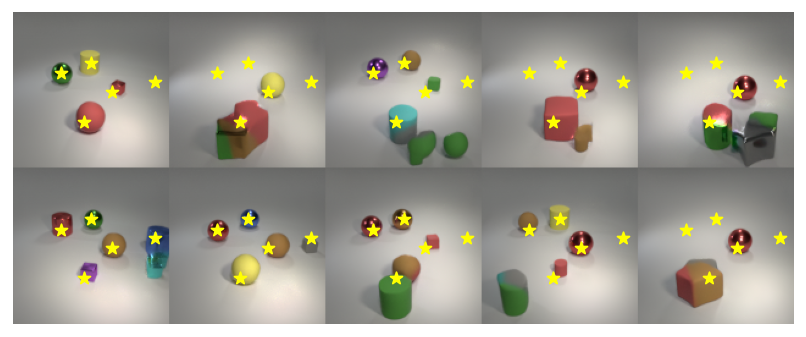

In [130]:
sample_at_final_t = samples_over_time[-1]
# normalize from [-1, 1] to [0, 1]
sample_at_final_t = (sample_at_final_t + 1) / 2

grid = make_grid(sample_at_final_t, nrow=5, padding=0)
grid_np = np.array(grid.cpu()).transpose(1, 2, 0)
plt.clf()
plt.close("all")
plt.figure()
plt.imshow(grid_np)
show_points(labels, 5, 2, plt.gca())
plt.axis('off')
plt.tight_layout()
plt.show()

yellow stars represent the positions we want the model to render objects. We see Composable Diffusion cannot satisfy all 5 constrants for some rendered images.

## Inference - CompLift

In [86]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

filtered_samples, unfiltered_samples_over_time, need_to_remove_across_timesteps, energies_across_timesteps = \
    baselines_clevr.rejection_baseline(
        composed_denoise_fn=lambda x, t: composed_fn(x, t, torch.from_numpy(labels).to(device)),
        unconditioned_denoise_fn=conditions_denoise_fn[-1],
        conditions_denoise_fn=conditions_denoise_fn[:-1],
        x_shape=(3, 128, 128),
        noise_scheduler=diffusion,
        num_samples_to_generate=10,
        rejection_scheduler_cfg=cfg.rejection_scheduler,
        elbo_cfg=cfg.elbo,
        progress=True,
    )

  0%|          | 0/100 [00:00<?, ?it/s]

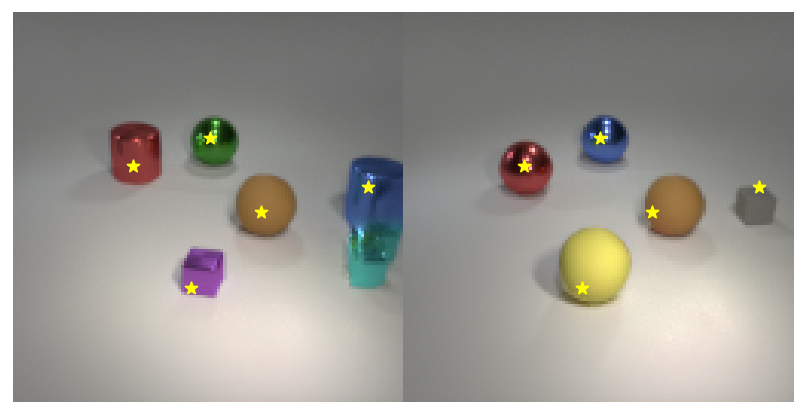

In [131]:
sample_at_final_t = filtered_samples
# normalize from [-1, 1] to [0, 1]
sample_at_final_t = (sample_at_final_t + 1) / 2

grid = make_grid(sample_at_final_t, nrow=len(sample_at_final_t), padding=0)
grid_np = np.array(grid.cpu()).transpose(1, 2, 0)
plt.clf()
plt.close("all")
plt.imshow(grid_np)
show_points(labels, len(sample_at_final_t), 1, plt.gca())
plt.axis('off')
plt.tight_layout()
plt.show()

CompLift rejects those images that likely not include the objects.

(NOTE: 
sometimes it happens that the CompLift is conservative and it rejects all images. In that case, we choose the image with the maximal *overall score* as the final result. The *overall score* is computed as the minimum lift score across all conditions. 
In particular,
``` python
score = torch.from_numpy(np.array(list(energies_across_timesteps.values())))[test_idx].min(dim=0).values
sample_at_final_t = unfiltered_samples_over_time[-1][score.argmax()]
```
)

See more details in `scripts/run_baselines_clevr.py`.

## Inference - Cached CompLift

In [134]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# create a cache callback to store the intermediate predictions
cache_callback = CacheCallback()
composed_fn = create_composed_model_fn(model, device, cfg, cache_callback)

filtered_samples, unfiltered_samples_over_time, is_valid, energies = \
    baselines_clevr.cache_rejection_baseline(
        composed_denoise_fn=lambda x, t: composed_fn(x, t, torch.from_numpy(labels).to(device)),
        unconditioned_denoise_fn=conditions_denoise_fn[-1],
        conditions_denoise_fn=conditions_denoise_fn[:-1],
        cache_callback=cache_callback,
        x_shape=(3, 128, 128),
        noise_scheduler=diffusion,
        num_samples_to_generate=10,
        elbo_cfg=cfg.elbo,
        progress=True,
    )

  0%|          | 0/100 [00:00<?, ?it/s]

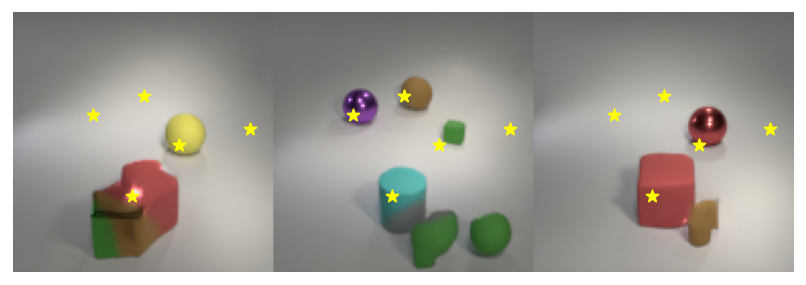

In [135]:
sample_at_final_t = filtered_samples
# normalize from [-1, 1] to [0, 1]
sample_at_final_t = (sample_at_final_t + 1) / 2

grid = make_grid(sample_at_final_t, nrow=len(sample_at_final_t), padding=0)
grid_np = np.array(grid.cpu()).transpose(1, 2, 0)
plt.clf()
plt.close("all")
plt.imshow(grid_np)
show_points(labels, len(sample_at_final_t), 1, plt.gca())
plt.axis('off')
plt.tight_layout()
plt.show()

NOTE: The performance of Cached CompLift is relatively unstable compared to CompLift, typically because we use only 1 trial in CLEVR task, and the noise is not i.i.d. for Cached CompLift.

## Inference - MCMC

Since the pretrained model is not an EBM, the MALA and HMC are not available. We only tried ULA and UHA for MCMC.

In [142]:
cfg.ebm.sampler_type = "ULA"  #  "UHA"

In [136]:
# Be aware of the running time! It would take around 12 minutes to run.

samples = baselines_clevr.ebm_baseline(
    composed_denoise_fn=lambda x, t: composed_fn(x, t, torch.from_numpy(labels).to(device)),
    x_shape=(3, 128, 128),
    noise_scheduler=diffusion,
    num_samples_to_generate=10,
    ebm_cfg=cfg.ebm,
    progress=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

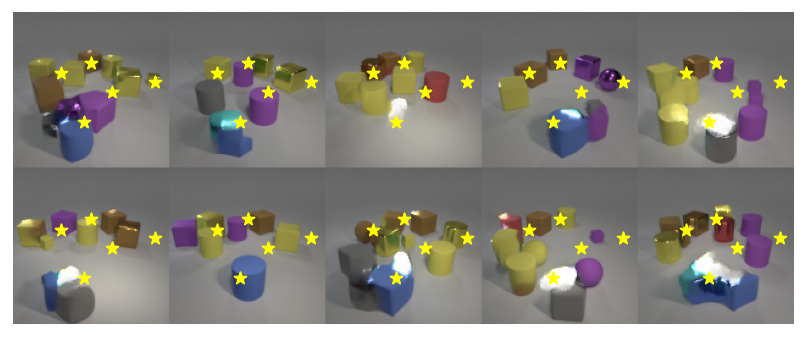

In [140]:
sample_at_final_t = samples[-1]
# normalize from [-1, 1] to [0, 1]
sample_at_final_t = (sample_at_final_t + 1) / 2

grid = make_grid(sample_at_final_t, nrow=5, padding=0)
grid_np = np.array(grid.cpu()).transpose(1, 2, 0)
plt.clf()
plt.close("all")
plt.imshow(grid_np)
show_points(labels, 5, 2, plt.gca())
plt.axis('off')
plt.tight_layout()
plt.show()

NOTE: Since EBM takes too much time to run, in practice we only use the first 100 test cases and compare them to other baselines. See more details in `scripts/run_baselines_clevr.py`.

## Inference - Classify with SAM2

Make sure that you've installed the [sam2](https://github.com/facebookresearch/sam2/tree/main) before proceeding this section.

We require the sam2 repo is installed under the same parent folder as `2d-and-clevr`.

In [5]:
import sam2
import os
from pathlib import Path

def check_sam2_location():
    # Get the current working directory
    current_dir = Path.cwd()
    
    # Get the parent directory
    parent_dir = current_dir.parent
    
    # Check if SAM2 directory exists under the parent directory
    sam2_path = parent_dir / 'sam2'
    
    if sam2_path.exists() and sam2_path.is_dir():
        print(f"sam2 repository found at: {sam2_path}")
        return True
    else:
        print(f"sam2 repository not found at expected location: {sam2_path}")
        return False

assert check_sam2_location()

import glob
assert len(glob.glob("../sam2/checkpoints/*.pt"))!=0, "Make sure to run `bash download_ckpts.sh` in ../sam2/checkpoints"

sam2 repository found at: /home/rainorangelemon/Documents/complift_os/sam2


In [6]:
from scripts.label_sam2 import SAMClassifier
from ddpm import device
import baselines_clevr
classifier = SAMClassifier(device=torch.device(device))

In [7]:
# generated images
torch.manual_seed(0)
torch.cuda.manual_seed(0)

samples_over_time = baselines_clevr.diffusion_baseline(
        denoise_fn=lambda x, t: composed_fn(x, t, torch.from_numpy(labels).to(device)),
        diffusion=diffusion,
        x_shape=(3, 128, 128),
        eval_batch_size=10)

final_sample = samples_over_time[-1]

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
# classify the generated images - takes around 8 seconds to run
successes, background_masks, draw_labels = classifier.classify_image_batch(final_sample, [labels]*len(final_sample))

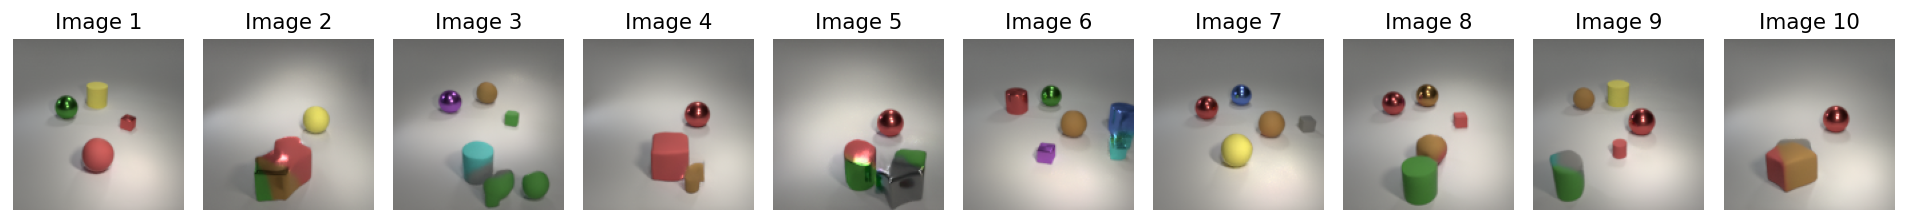

In [9]:
# Show generated images
plt.clf()
plt.close("all")
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i in range(10):
    axes[i].imshow(((final_sample[i] + 1) / 2).permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

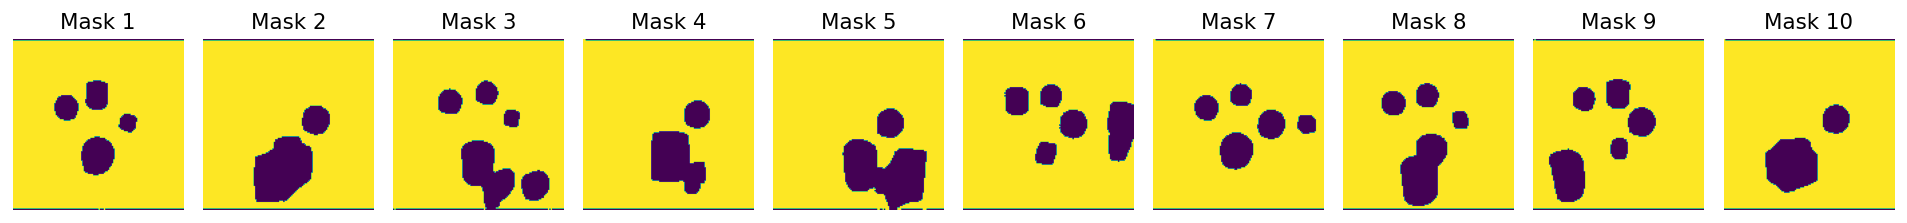

In [10]:
# Show background masks
plt.clf()
plt.close("all")
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i in range(10):
    axes[i].imshow(background_masks[i])
    axes[i].axis('off')
    axes[i].set_title(f'Mask {i+1}')

plt.tight_layout()
plt.show()

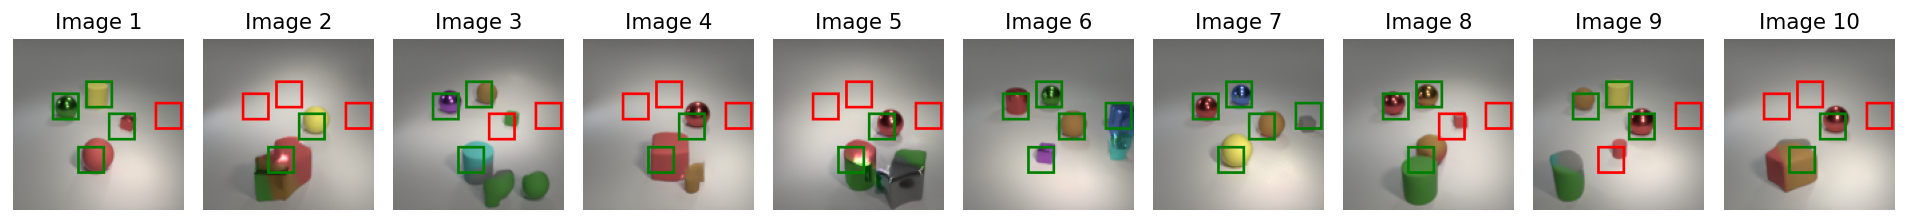

In [11]:
# Show the labels classified by SAM2

from PIL import Image, ImageDraw
def draw_bounding_box(draw, coord, success, image_size=128, box_size=20):
    """Draw a bounding box around a coordinate point with confidence score"""
    # Convert normalized coordinates to image coordinates
    x = coord[0] * image_size
    y = (1 - coord[1]) * image_size  # Flip y coordinate as per the show_points function

    # Calculate box boundaries
    half_size = box_size // 2
    left = max(x - half_size, 0)
    top = max(y - half_size, 0)
    right = min(x + half_size, image_size)
    bottom = min(y + half_size, image_size)

    # Draw the box with color based on success
    color = ["red", "green"][int(success)]
    draw.rectangle([left, top, right, bottom], outline=color, width=2)

plt.clf()
plt.close("all")
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i in range(10):
    img_np = ((final_sample[i] + 1) * 127.5).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    img = Image.fromarray(img_np)
    img_draw = ImageDraw.Draw(img)
    for coord, success in zip(labels, draw_labels[i]):
        draw_bounding_box(img_draw, coord, success)    
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

Congrats for completing the quickstart! For a more thorough comparison, feel free to check `2d-and-clevr/scripts/run_baselines_clevr.py`